In [161]:
import sentencepiece as spm
import pandas as pd
import numpy as np
import time

from sklearn.feature_extraction.text import *
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import string
import nltk
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [162]:
sp = spm.SentencePieceProcessor()
sp.Load('../mongolian_bert_sentencepiece/mn_uncased.model')

def sp_tokenize(w):
    return sp.EncodeAsPieces(w)

MAX_LEN = 512
stopwordsmn = ['аа','аанхаа','алив','ба','байдаг','байжээ','байна','байсаар','байсан',
               'байхаа','бас','бишүү','бол','болжээ','болно','болоо','бэ','вэ','гэж','гэжээ',
               'гэлтгүй','гэсэн','гэтэл','за','л','мөн','нь','тэр','уу','харин','хэн','ч',
               'энэ','ээ','юм','үү','?','', '.', ',', '-','ийн','ын','тай','г','ийг','д','н',
               'ний','дээр','юу']

def remove_stop_words(text):
    
    stop_words_removed = []

    for entry in text:
        sentences = nltk.sent_tokenize(entry)
        content_sentences_stopwords = []

        for sentence in sentences:
            tokens = nltk.word_tokenize(sentence)
            tokens = [w.lower() for w in tokens]
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            words = [word for word in stripped if word.isalpha()]
            words_stopwords = [w for w in words if not w in stopwordsmn]

            content_sentences_stopwords.append(words_stopwords)

        stop_words_removed.append(content_sentences_stopwords)
        
        
    for i in range(len(stop_words_removed)):
        stop_words_removed[i] = list(itertools.chain(*stop_words_removed[i]))[:MAX_LEN]
        stop_words_removed[i] = " ".join(stop_words_removed[i])
        
    return stop_words_removed

In [163]:
df_path = '../../main_dataset/'
trained_model_and_fitted_encoder_path = '../models/'
plots_path = '../plots/'

#df = pd.read_csv(df_path + '1111_only_mn.csv')

url = 'https://drive.google.com/file/d/1qLoomeZbKcgdvAPa44JUOzRMjq04pmpI/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]

df = pd.read_csv(path)
df = df.loc[df['type_text'] != 'Өргөдөл'].reset_index(drop = True)

print(df.shape)

(76063, 2)


In [164]:
import re

# Only removing numbers and hyphens
df['content'] = [re.sub('\d', '', sent) for sent in df['content']]
df['content'] = [re.sub(' \s+', ' ', sent) for sent in df['content']]
# Removing stopwords
df['content'] = remove_stop_words(df['content'])

In [165]:
# Stratified train and test split
train, test = train_test_split(df, test_size=0.1, random_state=999, stratify=df['type_text'])

# adding class_weight parameter to SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer(tokenizer=sp_tokenize, lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, 
                                           max_iter=5, random_state=0, class_weight = 'balanced'))])

t = time.time()
text_clf = text_clf.fit(train['content'], train['type_text'])
t = time.time()-t
print("Training time in seconds: ", t)

t = time.time()
predicted = text_clf.predict(test['content'])
t = time.time()-t
print("Prediction time in seconds: ", t)

print("Feature count:", len(text_clf.named_steps['vect'].vocabulary_))

acc = np.mean(predicted == test['type_text'])
print("Classifier accuracy: ", acc)

Training time in seconds:  7.0981690883636475
Prediction time in seconds:  0.7018592357635498
Feature count: 25689
Classifier accuracy:  0.749046930458788


<AxesSubplot:>

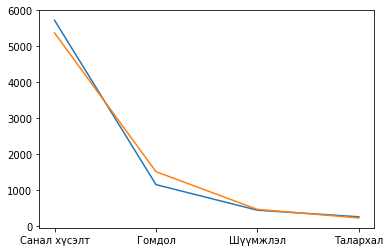

In [166]:
pred = pd.Series(predicted).value_counts()
real = test['type_text'].value_counts()

sns.lineplot(x = pred.index, y = pred.values)
sns.lineplot(x = real.index, y = real.values)

In [167]:
# Sample texts to classify intent
to_pred = ['Эмийн найдвартай байдлыг хангаж өгнө үү . Эм чимээгүй дайн үүсгэж байна.Ямарч баталгаа алга жнь: хугацаа нь дууссан гэх мэт',
           'Сайн байна уу? Та бүхэндээ баярлалаа. Миний санал: өмнөх жилийн удаан буудайн борлуулалтын үнэ 350000 төгрөг байсан. Энэ жил яагаад бууруулахгүй гэчихээд бага үнээр авав?',
           'Засгийн газраас хэрэглүүлж байгаа 100000 орон сууцны хөрөнгөө төрийн банкинд өгөөч ээ байрандаа ормоор байна',
           'Энэ засгийн газар хүн бүрд сая төгрөг өгөх болох уу?',
           'Ордноос шагнал авч байгаа хүмүүс их байна. Засгийн газрын баруун талд машин ачаад явж байна. Жилдээ нэг төрийн шагнал авч байгаа иргэдийг ингэж болдог юм уу.',
           'Эрүүл мэндийн даатгалаар Хөнгөлөлттэй эмийг эмийн сангууд сар бүрийн хэдний өдрөөс хэдний өдөр хүртэл олгодог талаар мэдээлэл өгнө үү? Мөн өрхийн эмнэлгүүд хэдэнд эмийн жор бичиж өгдөг вэ? Хөнгөлөлттэй эмийн талаар тодорхой мэдээлэл өгнө үү.',
           'БЗД ийн р хороо хогоо ачихгүй сар болж байна. Энэ тал дээр анхаарна уу.',
           'ХУД ийн р хорооны нийгмийн ажилтанд . р сард одонгийн материал бүрдүүлэх гэж хандтал хүүхэд ой хүрээгүй мөн материал бүрдүүлэлт авах болоогүй хүүхэд ой хүрсэн хойно авна гэсэн тайлбар хэлж буцаасан. .. нд Хүүхэд ой хүрсэн тул дахин асуудлаар хандтал материал бүрдүүлэлт дууссан шалтгаанаар хүлээж авсангүй. Уг асуудлаар холбогдох бүхий л шатны байгууллагад хандтал материал бүрдүүлэлт дууссан тул ямар ч боломжгүй гэж байна. Уг асуудлыг шийдвэрлэж иргэн намайг хохиролгүй болгож одонгийн материалыг минь хүлээж авч шийдвэрлэнэ үү.',
           'СБД ийн р хороо р байрны урд сагсны талбай дээр р сургууль биеийн тамирын хичээл орж шуугиан их гаргаж байна. Үүнээс болж оршин суугчдын амгалан тайван байдал алдагдуулж байна. Мөн сургуулийн сурагчид орцон дотор тамхи татаж байна. Арга хэмжээ авч өгнө үү.',
           'Хөвсгөл аймгийн Түнэл сумаас: Сэтгэцийн эрүүл мэндийн р тасагт хоног хэвтэж хүүхдээ эмчлүүлээд гарсан. Картан дээр нь ямар эмчилгээ хийлгэсэн талаар бичсэнгүй. Мөн ямарч зөвөлгөө өгсөнгүй. Эмчилгээ хийсэн эмч нь Насанжаргал. Одоо холбогдох гэхээр утсаа авахгүй байна. Ямар эмчилгээ хийлгэсэн болон одоо яах талаараа зөвөлгөө авахыг хүсч байна.'
          ]

to_pred = remove_stop_words(to_pred)

"""
for entry in to_pred:
    print('Text:', entry)
    print('Pred:', text_clf.predict([entry])[0], '\n')
"""

"\nfor entry in to_pred:\n    print('Text:', entry)\n    print('Pred:', text_clf.predict([entry])[0], '\n')\n"

In [168]:
# Really messy here!
def return_sentence_len(text):
    sent_len = [len(sent) for sent in text]

    return sent_len

def return_sentence_len_dist(pred, data):
    # Test set indexes for corresponding classes
    pred_sanal_idx = np.where(pred == 'Санал хүсэлт')[0].tolist()
    pred_gomdol_idx = np.where(pred == 'Гомдол')[0].tolist()
    pred_shuumjlel_idx = np.where(pred == 'Шүүмжлэл')[0].tolist()
    pred_talarhal_idx = np.where(pred == 'Талархал')[0].tolist()

    # Test set distribution of content feature sentences
    pred_sanal_sentence_len = return_sentence_len(data.iloc[pred_sanal_idx]['content'])
    pred_gomdol_sentence_len = return_sentence_len(data.iloc[pred_gomdol_idx]['content'])
    pred_shuumjlel_sentence_len = return_sentence_len(data.iloc[pred_shuumjlel_idx]['content'])
    pred_talarhal_sentence_len = return_sentence_len(data.iloc[pred_talarhal_idx]['content'])
    
    return [pred_sanal_sentence_len, pred_gomdol_sentence_len, pred_shuumjlel_sentence_len, pred_talarhal_sentence_len]

In [169]:
# For creating plot for each predicted class
def single_hist_plot(val, label, save_path):
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.set_title(f'Sentence length where model predicted "{label}"', fontsize = 18)

    ax.hist(val, color = 'green', alpha = 0.7);

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis = 'x', pad = 14, labelsize = 14)
    ax.tick_params(axis = 'y', pad = 5, labelsize = 10)

    ax.grid(alpha = 0.5, linestyle = '--', c = 'gray')
    fig.savefig(plots_path + save_path + f'{label}_length_distribution.png')
    
# Plotting all histograms on a single figure
def all_hist(val, save_path):
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.set_title('Balanced classes weights sentence length distibution for different classes', fontsize = 18)

    colors = ['green', 'red', 'yellow', 'blue']
    alphas = [0.7, 1, 1, 1]
    for i in range(4):
        ax.hist(val[i], color = colors[i], alpha = alphas[i]);

    ax.legend(['Санал Хүсэлт', 'Гомдол', 'Шүүмжлэл', 'Талархал'], fontsize = 14, frameon = False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis = 'x', pad = 14, labelsize = 14)
    ax.tick_params(axis = 'y', pad = 5, labelsize = 10)

    ax.grid(alpha = 0.5, linestyle = '--', c = 'gray')
    fig.savefig(plots_path + f'{save_path}.png')

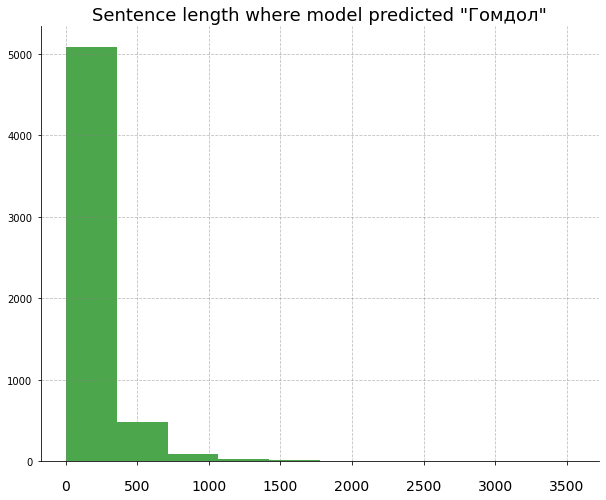

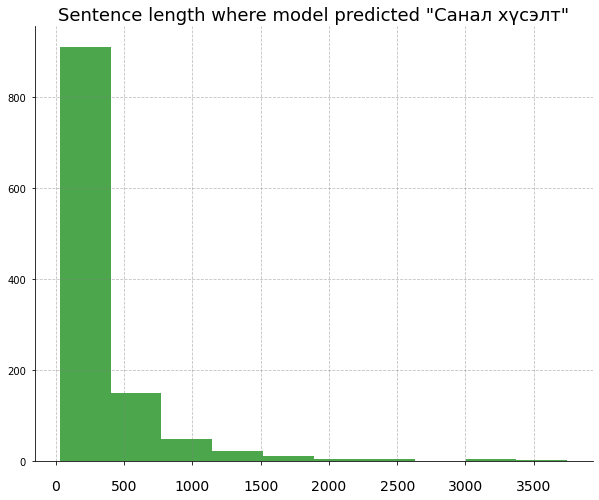

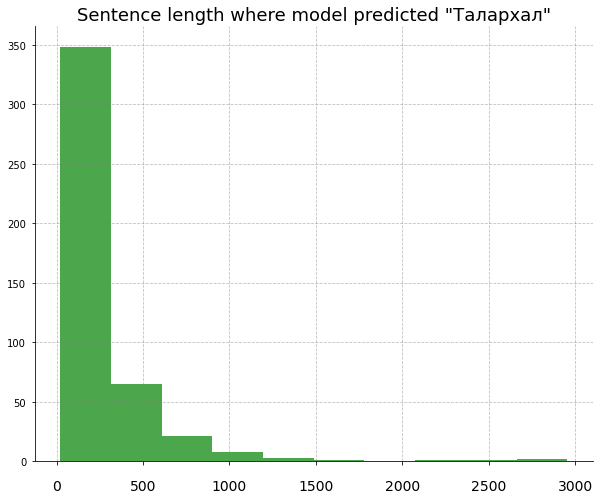

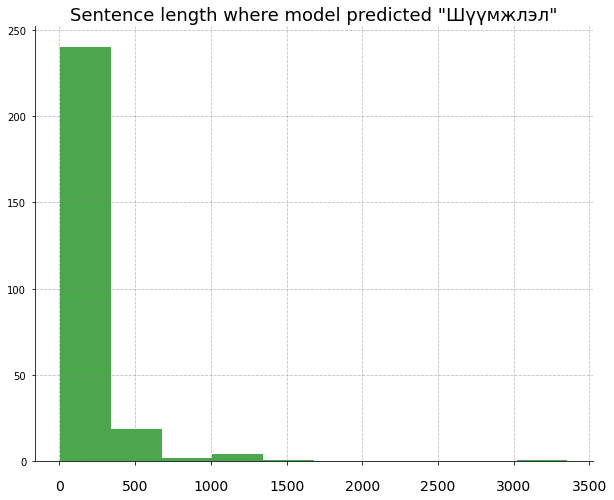

In [172]:
sentence_len_dist = return_sentence_len_dist(predicted, test)
labels = np.unique(df['type_text'])

for i in range(4):
    single_hist_plot(sentence_len_dist[i], labels[i], '')

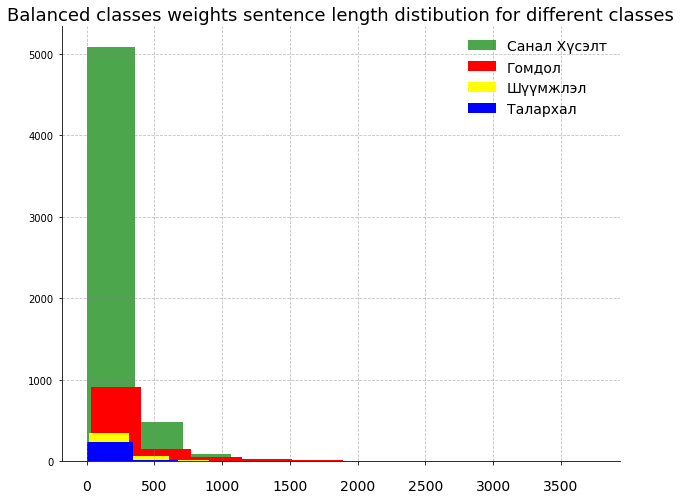

In [173]:
all_hist(sentence_len_dist, 'class_weights_balanced_dist')